# Imports

In [21]:
import numpy as np
import random
import heapq
import time
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Environment Setup

In [22]:
import numpy as np
import random
from collections import defaultdict
import pickle
import matplotlib.pyplot as plt

class DisasterZoneEnv:
    """
    A simplified 2D grid environment for a drone exploring a disaster zone.

    Legend:
      0 -> Empty cell
      1 -> Obstacle
      2 -> Survivor
      3 -> Resource
      D -> Drone (tracked separately, but displayed in render)
    """

    def __init__(self, width=8, height=8, num_obstacles=5, num_survivors=3, num_resources=2, initial_energy=20, dynamic=False):
        """
        Initialize the environment with configurable dimensions and grid contents.

        :param width: Width of the grid.
        :param height: Height of the grid.
        :param num_obstacles: Number of obstacles to place in the grid.
        :param num_survivors: Number of survivors to place in the grid.
        :param num_resources: Number of resources to place in the grid.
        :param initial_energy: Initial energy level of the drone.
        :param dynamic: Whether the environment is dynamic (changes during simulation).
        """
        self.width = width
        self.height = height
        self.num_obstacles = num_obstacles
        self.num_survivors = num_survivors
        self.num_resources = num_resources
        self.initial_energy = initial_energy
        self.dynamic = dynamic  # Enable or disable dynamic changes

        # Define possible actions - up, down, left, right
        self.action_space = {
            0: (-1, 0),  # up
            1: (1, 0),   # down
            2: (0, -1),  # left
            3: (0, 1)    # right
        }

        self.reset()

    def reset(self):
        """
        Resets the environment to a starting state.
        """
        self.grid = np.zeros((self.height, self.width), dtype=int)

        # Place obstacles randomly
        for _ in range(self.num_obstacles):
            x, y = self._get_random_empty_cell()
            self.grid[x, y] = 1

        # Place survivors randomly
        for _ in range(self.num_survivors):
            x, y = self._get_random_empty_cell()
            self.grid[x, y] = 2

        # Place resources randomly
        for _ in range(self.num_resources):
            x, y = self._get_random_empty_cell()
            self.grid[x, y] = 3

        # Drone's starting position
        self.drone_x, self.drone_y = self._get_random_empty_cell()
        self.energy = self.initial_energy

        return self._get_state()

    def _get_random_empty_cell(self):
        """
        Finds a random empty cell (not an obstacle, survivor, or resource).
        """
        while True:
            x = random.randint(0, self.height - 1)
            y = random.randint(0, self.width - 1)
            if self.grid[x, y] == 0:
                return x, y

    def _get_state(self):
        """
        Returns the current state, which includes:
        - Drone's position (x, y)
        - Drone's energy level
        - Information about the cells up, down, left, and right of the drone

        A* and Dijkstra can ignore self.around, but it is essential for Q-Learning
        """
        up = self.grid[self.drone_x - 1, self.drone_y] if self.drone_x > 0 else -1
        down = self.grid[self.drone_x + 1, self.drone_y] if self.drone_x < self.height - 1 else -1
        left = self.grid[self.drone_x, self.drone_y - 1] if self.drone_y > 0 else -1
        right = self.grid[self.drone_x, self.drone_y + 1] if self.drone_y < self.width - 1 else -1

    
        # Store surrounding information in a tuple
        self.around = (up, down, left, right)
    
        # Return the full state
        return (self.drone_x, self.drone_y, self.energy, self.around)


    def step(self, action):
        """
        Executes a step in the environment.
        """
        dx, dy = self.action_space[action]
        new_x = self.drone_x + dx
        new_y = self.drone_y + dy

        reward = 0
        done = False

        if not self._in_bounds(new_x, new_y):
            reward -= 10  # Penalty for trying to move out of bounds
        elif self.grid[new_x, new_y] == 1:  # Obstacle collision
            reward -= 10
        else:
            # Valid move
            self.drone_x, self.drone_y = new_x, new_y

            if self.grid[new_x, new_y] == 0:
                reward += 1  # Reward for moving to an empty cell
            elif self.grid[new_x, new_y] == 2:
                reward += 10  # Reward for rescuing a survivor
                self.grid[new_x, new_y] = 0  # Remove survivor
            elif self.grid[new_x, new_y] == 3:
                reward += 5  # Reward for collecting a resource
                self.energy += 5  # Add 5 energy when collecting a resource
                self.grid[new_x, new_y] = 0  # Remove resource

        # Energy cost per move
        self.energy -= 1
        reward -= 1  # Decrease reward for the energy spent moving

        if self.energy <= 0:
            done = True

        return self._get_state(), reward, done


    def _in_bounds(self, x, y):
        """Check if the position is within the grid boundaries."""
        return 0 <= x < self.height and 0 <= y < self.width

    def apply_dynamic_changes(self, step_count):
        """
        Applies dynamic changes to the grid, such as adding obstacles, moving survivors,
        and placing new resources, based on the current step count.

        :param step_count: The current simulation step.
        """
        if self.dynamic:
            # Add a new obstacle every 5 steps
            if step_count % 5 == 0:
                x, y = self._get_random_empty_cell()
                self.grid[x, y] = 1  # Add an obstacle
                #print(f"Dynamic Change: Added obstacle at ({x}, {y})")

            # Move survivors every 3 steps
            if step_count % 3 == 0:
                survivor_positions = [(x, y) for x in range(self.height)
                                      for y in range(self.width) if self.grid[x, y] == 2]
                for x, y in survivor_positions:
                    self.grid[x, y] = 0  # Remove survivor from the current position
                    new_x, new_y = self._get_random_empty_cell()
                    self.grid[new_x, new_y] = 2  # Place survivor in a new position
                    #print(f"Dynamic Change: Moved survivor from ({x}, {y}) to ({new_x}, {new_y})")

            # Add a new resource every 7 steps
            if step_count % 7 == 0:
                x, y = self._get_random_empty_cell()
                self.grid[x, y] = 3  # Add a resource
                #print(f"Dynamic Change: Added resource at ({x}, {y})")      
    
    def render(self):
        """
        Display the current environment state.
        """
        grid_copy = self.grid.astype(str)
        grid_copy[grid_copy == '0'] = '.'
        grid_copy[grid_copy == '1'] = '#'
        grid_copy[grid_copy == '2'] = 'S'
        grid_copy[grid_copy == '3'] = 'R'
        grid_copy[self.drone_x, self.drone_y] = 'D'

        for row in grid_copy:
            print(" ".join(row))
        print(f"Energy: {self.energy}\n")


# Agents classes

### Dijikstra agent

In [23]:
class DijkstraAgent:
    """
    An agent using Dijkstra's algorithm for pathfinding.
    """

    def __init__(self, env):
        self.env = env
        self.steps_taken = 0
        self.survivors_rescued = 0
        self.resources_collected = 0

    def dijkstra_search(self, grid, start, goal):
        import heapq
        directions = [(-1,0), (1,0), (0,-1), (0,1)]
        pq = [(0, start)]  # (distance, position)
        distances = {start: 0}
        previous = {start: None}

        while pq:
            current_dist, current_pos = heapq.heappop(pq)
            if current_pos == goal:
                # Reconstruct path
                path = []
                while current_pos is not None:
                    path.append(current_pos)
                    current_pos = previous[current_pos]
                path.reverse()
                return path, current_dist

            for dx, dy in directions:
                nx = current_pos[0] + dx
                ny = current_pos[1] + dy
                if 0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[1]:
                    # 1 => obstacle
                    if grid[nx, ny] != 1:
                        new_dist = current_dist + 1
                        if (nx, ny) not in distances or new_dist < distances[(nx, ny)]:
                            distances[(nx, ny)] = new_dist
                            previous[(nx, ny)] = current_pos
                            heapq.heappush(pq, (new_dist, (nx, ny)))

        return [], float('inf')

    def find_closest_target(self, target_type):
        """
        Find the path to the nearest cell with grid == target_type (2=Survivor or 3=Resource).
        """
        start = (self.env.drone_x, self.env.drone_y)
        targets = [
            (x, y) for x in range(self.env.height)
            for y in range(self.env.width)
            if self.env.grid[x, y] == target_type
        ]
        if not targets:
            return None, None, float('inf')

        best_path = None
        best_target = None
        best_dist = float('inf')

        for t in targets:
            path, dist = self.dijkstra_search(self.env.grid, start, t)
            if dist < best_dist:
                best_dist = dist
                best_path = path
                best_target = t

        return best_path, best_target, best_dist

    def execute(self):
        step_count = 0
        while self.env.energy > 0:
            # 1) look for survivors
            path, target_pos, _ = self.find_closest_target(2)
            if not path:
                # 2) then look for resources
                path, target_pos, _ = self.find_closest_target(3)

            if not path:
                print("No reachable targets. Stopping.")
                break

            # Move step by step
            for cell in path[1:]:
                self.env.drone_x, self.env.drone_y = cell
                self.steps_taken += 1
                step_count += 1

                # if environment is dynamic
                if self.env.dynamic:
                    self.env.apply_dynamic_changes(step_count)

                self.env.energy -= 1
                if self.env.energy <= 0:
                    break

            # If we actually reached a target
            if target_pos:
                cell_val = self.env.grid[target_pos[0], target_pos[1]]
                if cell_val == 2:
                    self.survivors_rescued += 1
                elif cell_val == 3:
                    self.resources_collected += 1
                # Mark empty
                self.env.grid[target_pos[0], target_pos[1]] = 0

### A* agent

In [24]:
class AStarAgent:
    """
    An agent that uses the A* search algorithm to navigate the DisasterZoneEnv.
    """

    def __init__(self, env):
        self.env = env
        self.steps_taken = 0
        self.survivors_rescued = 0
        self.resources_collected = 0

    def heuristic(self, a, b):
        # Manhattan distance
        return abs(a[0] - b[0]) + abs(a[1] - b[1])

    def a_star_search(self, grid, start, goal):
        import heapq
        directions = [(-1,0), (1,0), (0,-1), (0,1)]

        g_cost = {start: 0}
        f_cost = {start: self.heuristic(start, goal)}
        open_set = [(f_cost[start], start)]   # (f, cell)
        came_from = {start: None}

        while open_set:
            _, current = heapq.heappop(open_set)
            if current == goal:
                # reconstruct path
                path = []
                while current is not None:
                    path.append(current)
                    current = came_from[current]
                path.reverse()
                return path, g_cost[goal]

            for dx, dy in directions:
                nx = current[0] + dx
                ny = current[1] + dy
                if 0 <= nx < grid.shape[0] and 0 <= ny < grid.shape[1]:
                    if grid[nx, ny] != 1:  # not obstacle
                        tentative_g = g_cost[current] + 1
                        if (nx, ny) not in g_cost or tentative_g < g_cost[(nx, ny)]:
                            g_cost[(nx, ny)] = tentative_g
                            f_cost[(nx, ny)] = tentative_g + self.heuristic((nx, ny), goal)
                            came_from[(nx, ny)] = current
                            heapq.heappush(open_set, (f_cost[(nx, ny)], (nx, ny)))

        return [], float('inf')

    def find_closest_target(self, target_type):
        start = (self.env.drone_x, self.env.drone_y)
        targets = [
            (x, y) for x in range(self.env.height)
            for y in range(self.env.width)
            if self.env.grid[x, y] == target_type
        ]
        if not targets:
            print(f"No targets of type {target_type} found.")
            return None, None, float('inf')

        best_path = None
        best_target = None
        best_dist = float('inf')
        for t in targets:
            path, dist = self.a_star_search(self.env.grid, start, t)
            if dist < best_dist:
                best_dist = dist
                best_path = path
                best_target = t
        return best_path, best_target, best_dist

    def execute(self):
        step_count = 0
        while self.env.energy > 0:
            # 1) Try survivors
            path, target_pos, _ = self.find_closest_target(2)
            if not path:
                # 2) Then resources
                path, target_pos, _ = self.find_closest_target(3)

            if not path:
                print("No reachable targets. Stopping.")
                break

            for cell in path[1:]:
                self.env.drone_x, self.env.drone_y = cell
                self.steps_taken += 1
                step_count += 1

                if self.env.dynamic:
                    self.env.apply_dynamic_changes(step_count)

                self.env.energy -= 1
                if self.env.energy <= 0:
                    break

            # If we reached a target
            if target_pos:
                val = self.env.grid[target_pos[0], target_pos[1]]
                if val == 2:
                    self.survivors_rescued += 1
                elif val == 3:
                    self.resources_collected += 1
                # Mark cell empty
                self.env.grid[target_pos[0], target_pos[1]] = 0

### Q-learning agent

# Static / Dynamic scenrios to test on all agents

In [25]:
# Cell 4: Scenarios Dictionary

SCENARIOS_DICT = {
    "Scenario_1": {
        "name": "Simple Layout",
        "grid": np.array([
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 2, 0, 1, 0, 0, 3, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 2, 0, 0],
            [3, 0, 0, 0, 0, 0, 0, 'D']
        ], dtype=object),
        "dynamic": False,
        "description": "Minimal obstacles, static environment"
    },
    "Scenario_2": {
        "name": "Obstacle Maze",
        "grid": np.array([
            [0, 1, 1, 1, 0, 0, 0, 0],
            [0, 1, 2, 1, 0, 1, 1, 0],
            [0, 1, 0, 1, 0, 1, 0, 0],
            [0, 0, 0, 1, 0, 1, 0, 0],
            [0, 1, 0, 1, 0, 1, 0, 3],
            [0, 1, 0, 0, 0, 1, 0, 0],
            [0, 0, 0, 1, 0, 0, 2, 0],
            ['D', 1, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": False,
        "description": "A more complex layout"
    },
    "Scenario_3": {
        "name": "Dynamic Mixed Layout",
        "grid": np.array([
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 2, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 3, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0, 2, 0],
            [0, 0, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 3, 0, 0, 0, 0],
            ['D', 0, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": True,
        "description": "Dynamic environment with obstacles and survivors moving"
    },

    # Larger 12x12 static
    "Scenario_4": {
        "name": "Large 12x12 Static",
        "grid": np.array([
            [0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0],
            [0, 2, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0],
            [1, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1],
            [0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0],
            [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 2, 1, 0, 3, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
            [3, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 1, 3, 0, 2, 0, 0],
            ['D', 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": False,
        "description": "A bigger static scenario with more obstacles, survivors, resources"
    },

    # Larger 12x12 dynamic
    "Scenario_5": {
        "name": "Large 12x12 Dynamic",
        "grid": np.array([
            [0, 0, 0, 0, 0, 3, 0, 0, 2, 0, 0, 0],
            [0, 2, 1, 1, 0, 0, 1, 0, 0, 3, 0, 0],
            [1, 1, 1, 0, 0, 0, 0, 1, 2, 0, 0, 1],
            [0, 0, 0, 0, 3, 0, 0, 0, 1, 0, 0, 0],
            [0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0],
            [0, 0, 0, 1, 2, 1, 0, 3, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0],
            [3, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0],
            [0, 0, 0, 1, 0, 0, 3, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 0, 1, 3, 0, 2, 0, 0],
            ['D', 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0]
        ], dtype=object),
        "dynamic": True,
        "description": "A bigger dynamic scenario for differences between A* and Dijkstra"
    },
}


# Testing class for all agents

In [26]:
# Cell 5: Tester

class Tester:
    """
    Runs multiple agents on multiple scenarios, collects metrics into a results table.
    """

    def __init__(self, agent_classes, scenarios_dict, env_params=None):
        self.agent_classes = agent_classes
        self.scenarios_dict = scenarios_dict
        self.env_params = env_params if env_params else {}
        self.results = []

    def run_all_scenarios(self):
        for scenario_id, scenario_info in self.scenarios_dict.items():
            scenario_grid = scenario_info["grid"]
            scenario_name = scenario_info.get("name", scenario_id)
            scenario_dynamic = scenario_info.get("dynamic", False)
            scenario_desc = scenario_info.get("description", "")

            # Merge scenario-level dynamic with global env_params
            # i.e., if scenario_dynamic is True, we override env_params' dynamic
            param_dynamic = scenario_dynamic or self.env_params.get("dynamic", False)
            param_initial_energy = scenario_info.get("initial_energy", self.env_params.get("initial_energy", 20))

            # Optionally override other parameters if needed (like num_obstacles, seed, etc.)
            # but for now we just keep global env_params for these

            for agent_class in self.agent_classes:
                # Create environment
                env = DisasterZoneEnv(
                    width=self.env_params.get("width", 8),
                    height=self.env_params.get("height", 8),
                    num_obstacles=self.env_params.get("num_obstacles", 5),
                    num_survivors=self.env_params.get("num_survivors", 3),
                    num_resources=self.env_params.get("num_resources", 2),
                    initial_energy=param_initial_energy,
                    dynamic=param_dynamic,
                    predefined_grid=scenario_grid,
                    seed=self.env_params.get("seed", None),
                    recharge_amount=self.env_params.get("recharge_amount", None)
                )

                # Instantiate agent
                agent = agent_class(env)

                start_time = time.time()
                agent.execute()
                end_time = time.time()
                comp_time = end_time - start_time

                # Collect results
                self.results.append({
                    "Scenario ID": scenario_id,
                    "Scenario Name": scenario_name,
                    "Description": scenario_desc,
                    "Is Dynamic": param_dynamic,
                    "Agent Name": agent_class.__name__,
                    "Steps Taken": getattr(agent, "steps_taken", None),
                    "Survivors Rescued": getattr(agent, "survivors_rescued", None),
                    "Resources Collected": getattr(agent, "resources_collected", None),
                    "Energy Used": param_initial_energy - env.energy,
                    "Computation Time (s)": comp_time
                })

    def get_results_df(self):
        return pd.DataFrame(self.results)

    def save_results(self, filename="results.csv"):
        df = pd.DataFrame(self.results)
        df.to_csv(filename, index=False)
        print(f"Results saved to {filename}")


# Testing the code and agents

In [27]:
# Cell 6: Example Execution

# We'll compare Dijkstra and AStar on all scenarios
agent_list = [DijkstraAgent, AStarAgent]

# We'll test them with these default environment params
env_params = {
    "width": 12,           # We'll force a 12x12 grid for all, but scenario_1,2,3 are actually 8x8
                           # The scenario's shape actually overrides this for predefined grids, but that's okay.
    "height": 12,
    "num_obstacles": 5,    # For random scenario usage only
    "num_survivors": 3,
    "num_resources": 2,
    "initial_energy": 25,  # Slightly higher energy to handle bigger grids
    "dynamic": False,      # We'll rely on scenario dict for dynamic= True or False
    "seed": 42             # Reproducible
}

# Instantiate the tester
tester = Tester(agent_classes=agent_list, scenarios_dict=SCENARIOS_DICT, env_params=env_params)

# Run all scenarios
tester.run_all_scenarios()

# Get results as DataFrame
df_results = tester.get_results_df()
print(df_results)

# Optionally save
tester.save_results("results_comparison.csv")


No targets of type 2 found.
No targets of type 2 found.
No reachable targets. Stopping.
No targets of type 2 found.
No targets of type 2 found.
No targets of type 3 found.
No reachable targets. Stopping.
  Scenario ID         Scenario Name  \
0  Scenario_1         Simple Layout   
1  Scenario_1         Simple Layout   
2  Scenario_2         Obstacle Maze   
3  Scenario_2         Obstacle Maze   
4  Scenario_3  Dynamic Mixed Layout   
5  Scenario_3  Dynamic Mixed Layout   
6  Scenario_4    Large 12x12 Static   
7  Scenario_4    Large 12x12 Static   
8  Scenario_5   Large 12x12 Dynamic   
9  Scenario_5   Large 12x12 Dynamic   

                                         Description  Is Dynamic  \
0              Minimal obstacles, static environment       False   
1              Minimal obstacles, static environment       False   
2                              A more complex layout       False   
3                              A more complex layout       False   
4  Dynamic environment wit

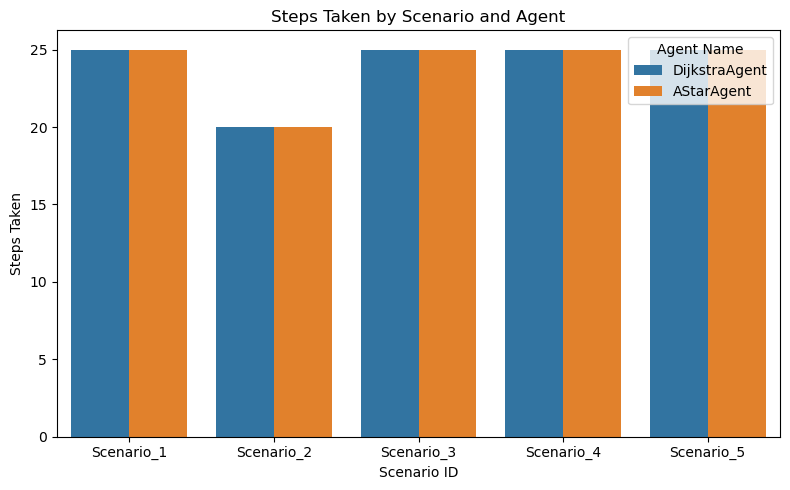

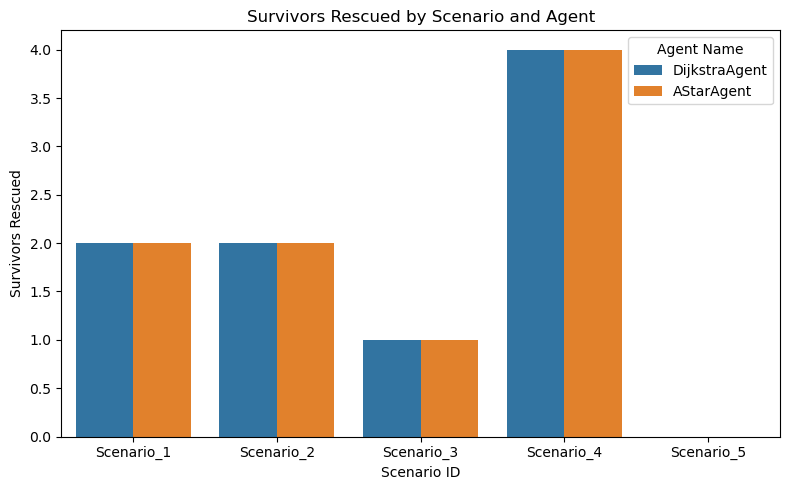

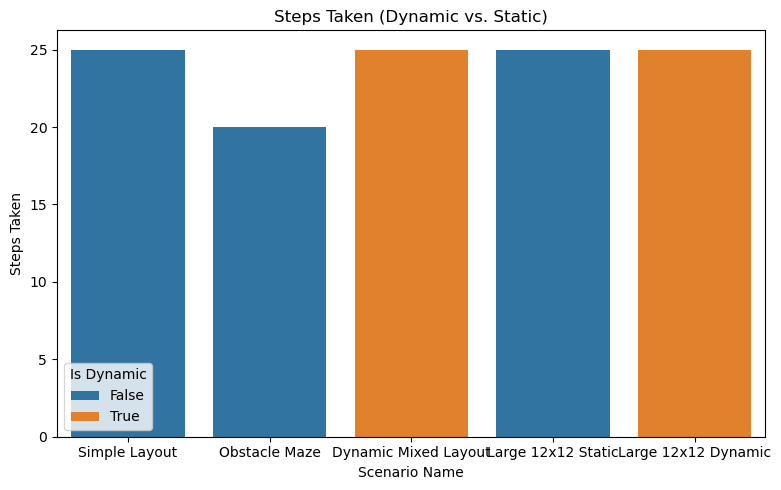

In [28]:
df = df_results  # for convenience

# 1) Basic bar plot of "Steps Taken"
plt.figure(figsize=(8,5))
sns.barplot(data=df, x="Scenario ID", y="Steps Taken", hue="Agent Name")
plt.title("Steps Taken by Scenario and Agent")
plt.tight_layout()
plt.show()

# 2) Survivors Rescued
plt.figure(figsize=(8,5))
sns.barplot(data=df, x="Scenario ID", y="Survivors Rescued", hue="Agent Name")
plt.title("Survivors Rescued by Scenario and Agent")
plt.tight_layout()
plt.show()

# 3) If you want to see how dynamic vs static differ, you can do e.g.:
plt.figure(figsize=(8,5))
sns.barplot(data=df, x="Scenario Name", y="Steps Taken", hue="Is Dynamic")
plt.title("Steps Taken (Dynamic vs. Static)")
plt.tight_layout()
plt.show()
